# Determinando o status de extinção de chamas de combustível com ondas sonoras por métodos de aprendizado de máquina.

  O conjunto de dados foi obtido do Kaggle e traz os resultados de testes  quatro tipos de chamas de diferentes combustíveis. A avaliação e metrificação do experimento foi feito usando ondas sonoras.
  Um total de 17.442 testes foram realizados com esta configuração experimental. Os experimentos foram planejados da seguinte forma:

- Três combustíveis líquidos diferentes e combustível GLP foram usados ​​para criar a chama.
- 5 tamanhos diferentes de latas de combustível líquido foram usados ​​para atingir diferentes tamanhos de chamas.
- O ajuste de meio e cheio de gás é usado para combustível GLP.
- Durante a realização de cada experimento, o recipiente de combustível, a 10 cm de distância, foi movido para frente até 190 cm, aumentando a distância em 10 cm a cada vez.
- Junto com o recipiente de combustível, o anemômetro e o decibelímetro (ferramentas utilizadas para medição) foram movidos para frente nas mesmas dimensões.

Experimentos de extinção de incêndio foram conduzidos com 54 ondas sonoras de frequências diferentes em cada distância e tamanho de chama.

Ao longo dos experimentos de extinção de chama, os dados obtidos de cada dispositivo de medição foram registrados e um conjunto de dados foi criado. O conjunto de dados inclui:
1. as características do tamanho do recipiente de combustível representando o tamanho da chama;
2. o tipo de combustível;
3. a frequência
4. os decibéis;
5. a distância;
6. e o fluxo de ar e extinção da chama. 

Assim, 6 recursos de entrada e 1 recurso de saída (status) serão usados ​​no modelo. 

A propriedade de status (extinção de chama ou estados de não extinção) pode ser prevista usando esses seis recursos no conjunto de dados. Os recursos de status e combustível são categóricos, enquanto outros recursos são numéricos. 

8.759 dos 17.442 resultados de teste são o estado de não extinção da chama.
8.683 deles são o estado de extinção da chama. De acordo com esses números, pode-se dizer que a distribuição de classes do conjunto de dados é quase igual.

In [1]:
# importando as ferramentas necessárias

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from matplotlib import pyplot as plt
from sklearn import tree

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/Acoustic_Extinguisher_Fire_Dataset.csv", error_bad_lines=False, delimiter=";")

Deu um erro no download inicial por conta da conversão do arquivo de xlsx para csv. Mas colocando para o Pandas não interpretar linhas com erro e que o delimitador é ';' e não ',' (isso acontece quando o software tem formatação americana), o import deu certo.

In [5]:
# conferindo se deu certo

df.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0,75,0
1,1,gasoline,10,96,0,72,1
2,1,gasoline,10,96,"2,6",70,1
3,1,gasoline,10,96,"3,2",68,1
4,1,gasoline,10,109,"4,5",67,1


# Análises estatísticas iniciais

In [6]:
# Análises inciais

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SIZE       17442 non-null  int64 
 1   FUEL       17442 non-null  object
 2   DISTANCE   17442 non-null  int64 
 3   DESIBEL    17442 non-null  int64 
 4   AIRFLOW    17442 non-null  object
 5   FREQUENCY  17442 non-null  int64 
 6   STATUS     17442 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 954.0+ KB


Sem dados faltantes.

In [7]:
df.describe()

,SIZE,DISTANCE,DESIBEL,FREQUENCY,STATUS
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,3.411765,100.000000,96.379142,31.611111,0.497821
std,1.750977,54.773826,8.164096,20.939149,0.500010
min,1.000000,10.000000,72.000000,1.000000,0.000000
25%,2.000000,50.000000,90.000000,14.000000,0.000000
50%,3.000000,100.000000,95.000000,27.500000,0.000000
75%,5.000000,150.000000,104.000000,47.000000,1.000000
max,7.000000,190.000000,113.000000,75.000000,1.000000


In [8]:
df.shape

(17442, 7)

As contagens batem todas, a média circula entre valores razoáveis e todas outras informações (os quartis, por exemplo), seguem valores cabíveis e dentro de intervalos razoáveis. Não há incosistência evidente aparentemente nos dados.

O único problema é que a feature "AIRFLOW" está em formato object (string), apesar de ser um valor numérico. Isso porquê a vírgula não é interpretada como um caractere numérico. Vamos trocar por ponto e depois converter de object para float64.

In [9]:
df["AIRFLOW"] = df['AIRFLOW'].str.replace(",", ".")
df["AIRFLOW"]

0          0
1          0
2        2.6
3        3.2
4        4.5
        ... 
17437    2.2
17438      2
17439    1.5
17440    0.4
17441      0
Name: AIRFLOW, Length: 17442, dtype: object

In [10]:
df = df.astype({"AIRFLOW": float})

In [11]:
df.describe()

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,3.411765,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,150.000000,104.000000,11.200000,47.000000,1.000000
max,7.000000,190.000000,113.000000,17.000000,75.000000,1.000000


Pronto. Agora podemos analisar a feature AIRFLOW também e ficamos apenas com os tipos de combustíveis como categóricos.

Na hora do desenvolvimento do modelo vamos convertê-los para numérico também.

# Análise Exploratória

Vamos analisar agora o comportamento dos dados e as principais diferenças quando há ou não extinção de chama.


In [12]:
df.columns

Index(['SIZE', 'FUEL', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY',
       'STATUS'],
      dtype='object')

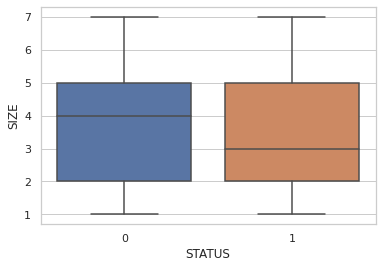

In [13]:
ax = sns.boxplot(x="STATUS", y="SIZE", data=df)

Pelo que os dados nos trazem, o status 0, equivalente ao de não-extinção da chama, costuma apresentar uma mediana de tamanho de chamas maior que o status 1, equivalente ao de extinção da chama. Isso porquê a linha da média no boxplot do status 0 é superior a linha média do status 1. No mais, os intervalos de variação (máximo e mínimo) parecem similares (7 e 1, respectivamente) e o primeiro e terceiro quartil parecem estar próximos também.

Vamos entrar em mais detalhes avaliando os quartis e conferir o comportamento da média, que deve seguir a proporcionalidade da mediana.

In [14]:
print("STATUS: 0")
print(df.query("STATUS==0")["SIZE"].describe())
print("-----------")
print("STATUS: 1")
df.query("STATUS==1")["SIZE"].describe()

STATUS: 0
count    8759.000000
mean        3.580774
std         1.669570
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         7.000000
Name: SIZE, dtype: float64
-----------
STATUS: 1


count    8683.000000
mean        3.241276
std         1.813637
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         7.000000
Name: SIZE, dtype: float64

Realmente, a média do status 0 é superior ao do 1, como imaginamos.

Seu desvio padrão é inferior também, o que indica que a maioria dos valores está mais próximo da média no status 0 quando comparado ao status 1, o que pode indicar que o tamanho das chamas é mais homogêneo quando estamos observando status de não-extinção de chama. Ou seja, o tamanho das chamas varia mais quando o status é 1 do que quando é 0.

In [15]:
print(f"Mediana do status de não-extinção da chama (0):", df.query("STATUS==0")["SIZE"].median())
print(f"Mediana do status de extinção da chama (1):",df.query("STATUS==1")["SIZE"].median())

Mediana do status de não-extinção da chama (0): 4.0
Mediana do status de extinção da chama (1): 3.0


Os números da mediana no boxplot eram exatos.

Vamos analisar agora a distância:

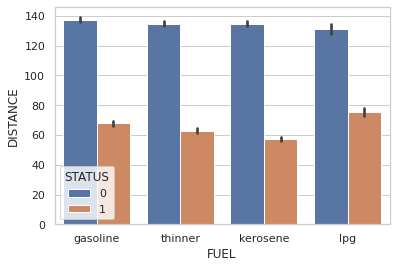

In [16]:
ax = sns.barplot(x="FUEL", y="DISTANCE", hue="STATUS", data=df)

Podemos obserevar que a média da distãncia é significativamente superior, para todos os tipos de combustíveis usados no experimento, quando comparamos a não-extinção da chama (status 0) com sua extinção (status 1).

Isso faz muito sentido na verdade porquê a distância ia aumentando de 10 em 10 cm e parava quando a chama se apagava. Naturalmente, se o status for 1 e houve a extinção da chama, é de se esperar que isso tenha ocorrido em uma distância menor quando comparado ao status de não-extinção.

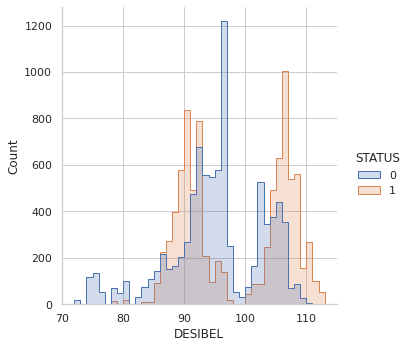

In [17]:
sns.displot(df, x="DESIBEL",  binwidth=1, hue='STATUS', element="step")

Quando analisamos a feature DESIBEL, que traz a medição da intensidade do som no experimento, podemos ver que a média é claramente diferente quando o status é 0 e quando é 1. 

Aparentemente, os dois status seguem "duas" distribuições normais, uma em seguida da outra.

O ponto mais alto de cada curva (laranja e azul) representam os valores com a maior moda do processo, ou seja, os valores que mais aparecem na base de dados.
Já podemos notar que esses valores variam quando analisamos status de extinção comparados a de não-extinção. 

Os outros cortes verticais, representam o desvio padrão em relação a média, ou seja, temos uma faixa de valores que significa a soma ou subtração de um desvio padrão em relação a média. 

Vamos confirmar essas informações:

In [18]:
print("STATUS: 0")
print(df.query("STATUS==0")["DESIBEL"].describe())
print(f"Moda:", df.query("STATUS==0")["DESIBEL"].mode())
print("-----------")
print("STATUS: 1")
print(df.query("STATUS==1")["DESIBEL"].describe())
print(f"Moda:", df.query("STATUS==1")["DESIBEL"].mode())

STATUS: 0
count    8759.000000
mean       94.721201
std         7.590086
min        72.000000
25%        91.000000
50%        95.000000
75%       102.000000
max       110.000000
Name: DESIBEL, dtype: float64
Moda: 0    96
dtype: int64
-----------
STATUS: 1
count    8683.000000
mean       98.051595
std         8.379248
min        75.000000
25%        90.000000
50%        96.000000
75%       106.000000
max       113.000000
Name: DESIBEL, dtype: float64
Moda: 0    106
dtype: int64


Como observamos no gráfico, a média, moda e desvio padrão são diferentes nos dois status. Isso é bem bom e indica que o modelo deve se comportar bem e ter uma acurácia alta porquê os valores para a maioria dos features são bem diferentes quando comparamos os status.

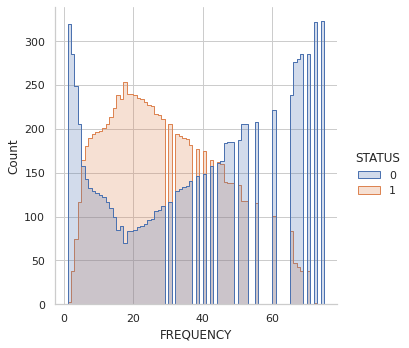

In [19]:
sns.displot(df, x="FREQUENCY", binwidth=1, hue='STATUS', element="step")

O mesmo se repete com a feature FREQUENCY. A distribuição da frequência é bem diferente entre os status e apenas o status 1 aparenta seguir uma distribuição normal.

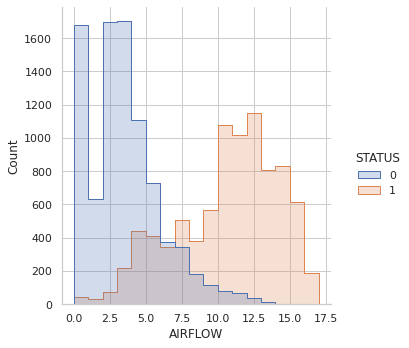

In [20]:
sns.displot(df, x="AIRFLOW", binwidth=1, hue='STATUS', element="step")

Novamente, com a feature AIRFLOW os dados são bem distintos ao separarmos por status. Bom para o modelo.

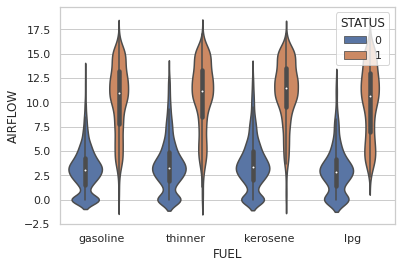

In [21]:
sns.violinplot(data=df, x="FUEL", y="AIRFLOW", hue="STATUS")

Esse segundo gráfico deixa mais visível a diferença encontrada nos status quando tratamos da feature AIRFLOW. O gráfico acima é um boxplot por tipo de combustível avaliando a feature AIRFLOW no eixo y e separando por tipo de status.

Adicionamos ainda o "violino" que traz a densidade dos pontos. De forma simples podemos observar que a quando o status é 1, a vasta maioria dos pontos se localiza acima de um AIRFLOW de 7.5 enquanto quando o status é 0, a maioria dos valores do AIRFLOW costumam estar abaixo de 5.0.

Como observado no gráfico de distribuição acima desse, a maioria das intersecções está localizada de 5.0 a 7.5, ou seja,um AIRFLOW nesse intervalo tem praticamente chances iguais de ter status 0 ou 1, mas quando o AIRFLOW tem um valor alto, a chance de ser status 1 é muito maior; e quanto tem um valor baixo, a chance de ser um status 0 que é muito maior.

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 93.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 84.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, '')]

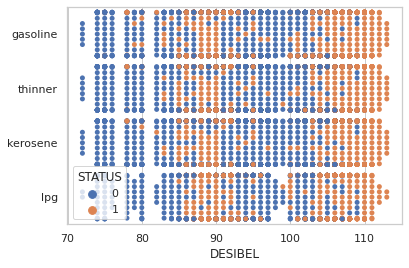

In [22]:
ax = sns.swarmplot(data=df, x="DESIBEL", y="FUEL", hue="STATUS")
ax.set(ylabel="")

Mais uma análise, agora usando um scatterplot e separando em tipos de combustíveis, status e medindo pelo desibel. 

Fica bem claro que, independenetemente do tipo de combustível, quando o status é 1 o desibel assume ou o valor no intervalo de 87-90 (aproximadamente) ou valores superiores a 107 (aproximadamente).

Valores abaixo de 85 são majoritariamente status 0.

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 94.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 85.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0.5, '')]

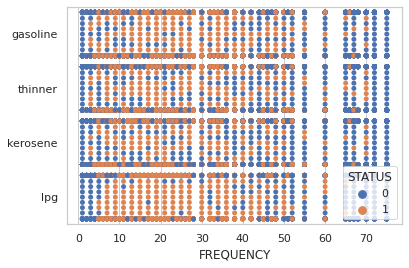

In [23]:
ax = sns.swarmplot(data=df, x="FREQUENCY", y="FUEL", hue="STATUS")
ax.set(ylabel="")

Ao fazermos a mesma análise com a frequência no eixo x, entretanto, podemos observar que não existe um padrão tão claro quanto o desibel quando separamos por status e tipo de combustível e os dados parecem estar mais misturados. Ou seja, não dá pra concluir muita coisa, a não ser supor que a correlação dessa variável com a status não deve ser muito alta.

Vamos analisar a correlação:

In [24]:
cor= df.corr()
cor

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
SIZE,1.000000e+00,-2.437871e-15,-6.125585e-15,1.677898e-16,9.978281e-17,-0.096947
DISTANCE,-2.437871e-15,1.000000e+00,-2.385897e-01,-7.074906e-01,-2.452947e-17,-0.644051
DESIBEL,-6.125585e-15,-2.385897e-01,1.000000e+00,3.769153e-01,5.617409e-01,0.203970
AIRFLOW,1.677898e-16,-7.074906e-01,3.769153e-01,1.000000e+00,-2.120462e-01,0.760628
FREQUENCY,9.978281e-17,-2.452947e-17,5.617409e-01,-2.120462e-01,1.000000e+00,-0.244203
STATUS,-9.694718e-02,-6.440506e-01,2.039698e-01,7.606279e-01,-2.442030e-01,1.000000


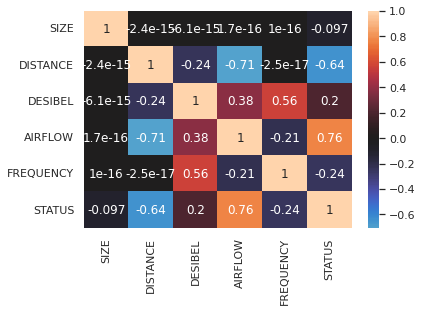

In [25]:
sns.heatmap(cor, center=0, annot=True)

As variáveis com maior influência no status são aquelas cuja o valor da correlação se aproxima mais de 1 (se for diretamente proporcional: se essa variável aumentar, o status aumenta também) ou de -1 (se for inversamente proporcional: se essa variável aumentar, o status diminui).

No caso, podemos observar que a distância e airflow são as que tem maior impacto. Desibel e frequência tem um impacto menor e size praticamente não impacta.

Vamos agora converter a variável categórica do tipo de combustível e avaliar sua correlação também.

In [26]:
df2 = pd.get_dummies(df)
df2

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS,FUEL_gasoline,FUEL_kerosene,FUEL_lpg,FUEL_thinner
0,1,10,96,0.0,75,0,1,0,0,0
1,1,10,96,0.0,72,1,1,0,0,0
2,1,10,96,2.6,70,1,1,0,0,0
3,1,10,96,3.2,68,1,1,0,0,0
4,1,10,109,4.5,67,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
17437,7,190,86,2.2,5,0,0,0,1,0
17438,7,190,84,2.0,4,0,0,0,1,0
17439,7,190,80,1.5,3,0,0,0,1,0
17440,7,190,76,0.4,2,0,0,0,1,0


In [27]:
cor2 = df2.corr()
cor2

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS,FUEL_gasoline,FUEL_kerosene,FUEL_lpg,FUEL_thinner
SIZE,1.000000e+00,-2.437871e-15,-6.125585e-15,1.677898e-16,9.978281e-17,-0.096947,-1.518013e-01,-1.518013e-01,6.440385e-01,-1.518013e-01
DISTANCE,-2.437871e-15,1.000000e+00,-2.385897e-01,-7.074906e-01,-2.452947e-17,-0.644051,1.558397e-15,-5.935704e-16,-1.960756e-15,4.223967e-16
DESIBEL,-6.125585e-15,-2.385897e-01,1.000000e+00,3.769153e-01,5.617409e-01,0.203970,1.974653e-14,-1.127608e-14,-1.048207e-15,-7.776103e-15
AIRFLOW,1.677898e-16,-7.074906e-01,3.769153e-01,1.000000e+00,-2.120462e-01,0.760628,8.633076e-16,-9.597026e-17,-1.436983e-16,-7.594794e-16
FREQUENCY,9.978281e-17,-2.452947e-17,5.617409e-01,-2.120462e-01,1.000000e+00,-0.244203,1.818456e-16,9.573714e-16,4.238185e-16,-1.464692e-15
STATUS,-9.694718e-02,-6.440506e-01,2.039698e-01,7.606279e-01,-2.442030e-01,1.000000,4.911776e-02,-6.412844e-02,4.465479e-02,-1.656503e-02
FUEL_gasoline,-1.518013e-01,1.558397e-15,1.974653e-14,8.633076e-16,1.818456e-16,0.049118,1.000000e+00,-4.166667e-01,-2.357023e-01,-4.166667e-01
FUEL_kerosene,-1.518013e-01,-5.935704e-16,-1.127608e-14,-9.597026e-17,9.573714e-16,-0.064128,-4.166667e-01,1.000000e+00,-2.357023e-01,-4.166667e-01
FUEL_lpg,6.440385e-01,-1.960756e-15,-1.048207e-15,-1.436983e-16,4.238185e-16,0.044655,-2.357023e-01,-2.357023e-01,1.000000e+00,-2.357023e-01
FUEL_thinner,-1.518013e-01,4.223967e-16,-7.776103e-15,-7.594794e-16,-1.464692e-15,-0.016565,-4.166667e-01,-4.166667e-01,-2.357023e-01,1.000000e+00


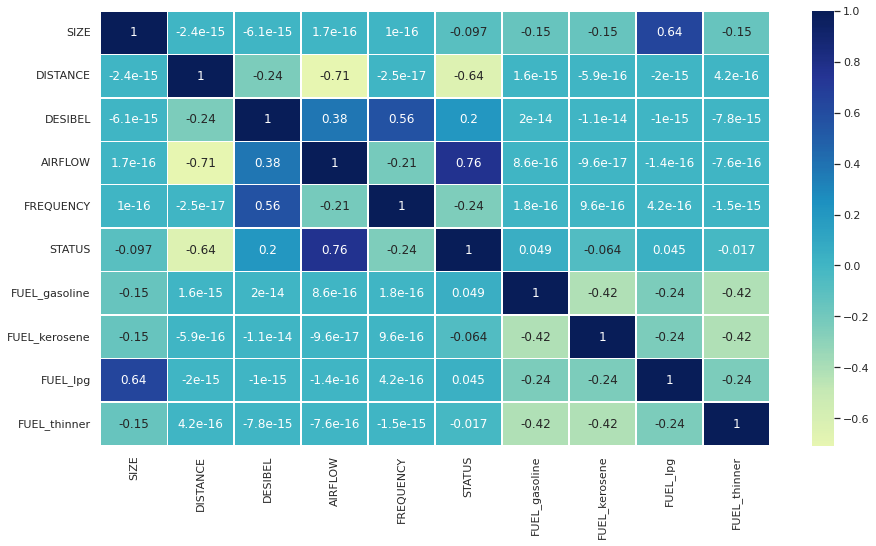

In [28]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(cor2, center=0, annot=True, cmap="YlGnBu", linewidths=.5)

Realmente, o tipo de combustível tem baixa influência no status final, todas as correlações iniciam em 0.0.

Vamos ao modelo de árvore de decisão.

Inicialmente vamos usar apenas os features DISTANCE, AIRFLOW, DESIBEL e FREQUENCY.

In [29]:
df.columns

Index(['SIZE', 'FUEL', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY',
       'STATUS'],
      dtype='object')

In [30]:
X = df[["DISTANCE", "DESIBEL", "AIRFLOW", "FREQUENCY"]]

Y = df["STATUS"]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


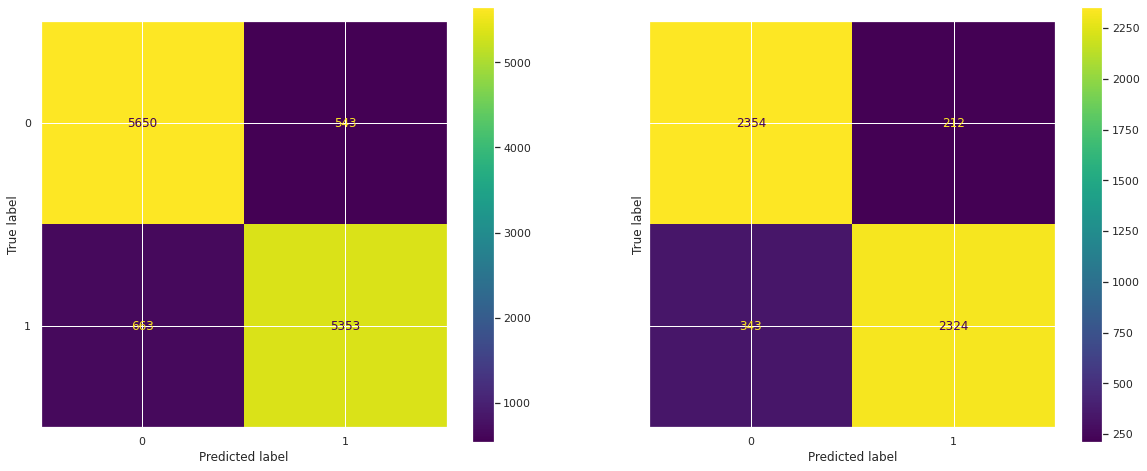

In [31]:
# Árvore de decisão

X_trainA, X_testA, y_trainA, y_testA = train_test_split( X, Y, test_size=0.3)

decisionTree = DecisionTreeClassifier().fit(X_trainA, y_trainA)

fig, axs = plt.subplots(ncols = 2, sharey= True, figsize = (20, 8))

plot_confusion_matrix(decisionTree, X_trainA, y_trainA, values_format= 'd', ax = axs[0])

plot_confusion_matrix(decisionTree, X_testA, y_testA,  values_format= 'd', ax = axs[1])

Vamos avaliar a árvore em si agora:

[Text(0.5, 0.875, 'AIRFLOW <= 7.25\ngini = 0.5\nsamples = 100.0%\nvalue = [0.507, 0.493]\nclass = 0'),
 Text(0.25, 0.625, 'AIRFLOW <= 3.95\ngini = 0.28\nsamples = 55.9%\nvalue = [0.832, 0.168]\nclass = 0'),
 Text(0.125, 0.375, 'DISTANCE <= 45.0\ngini = 0.107\nsamples = 34.8%\nvalue = [0.943, 0.057]\nclass = 0'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'FREQUENCY <= 26.5\ngini = 0.457\nsamples = 21.0%\nvalue = [0.647, 0.353]\nclass = 0'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'DISTANCE <= 85.0\ngini = 0.174\nsamples = 44.1%\nvalue = [0.096, 0.904]\nclass = 1'),
 Text(0.625, 0.375, 'AIRFLOW <= 9.8\ngini = 0.069\nsamples = 34.0%\nvalue = [0.036, 0.964]\nclass = 1'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'FREQUENCY <= 37.0\ngini = 0.42\nsamples = 10.1%\nvalue = [0.3, 0.7]\nclass = 1'),
 Text(0.8125, 0.125, '\n  (...

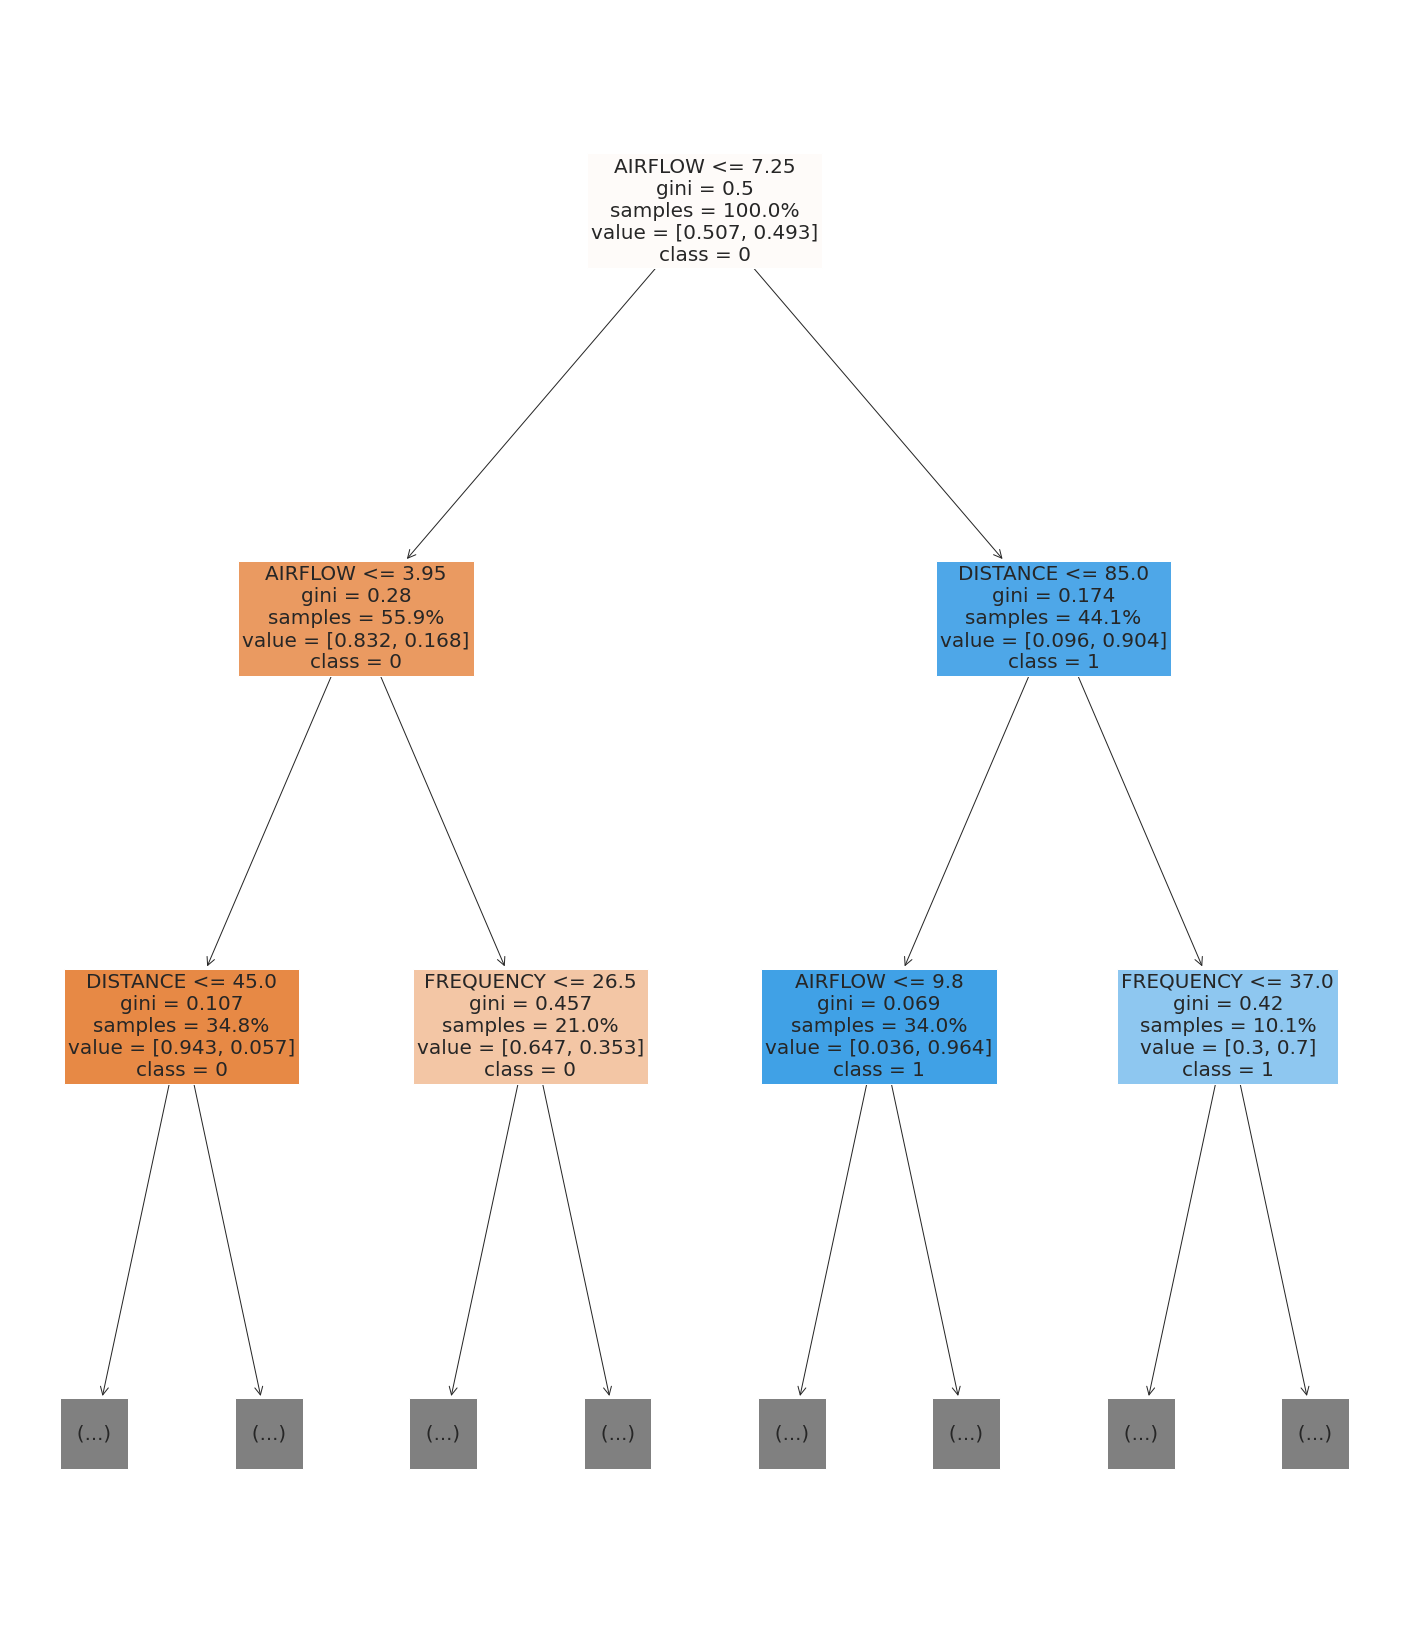

In [32]:
fig = plt.figure(figsize=(25, 30)) 
tree.plot_tree(decisionTree,
               max_depth=2,
               feature_names=["DISTANCE", "DESIBEL", "AIRFLOW", "FREQUENCY"],
               class_names= ['0', '1'],
               proportion=True,
               fontsize=20,
               filled=True)

Tivemos que colocar alguns parâmetros caso contrário a árvore iria ficar gigantesca e pouco visual. Legal observar qual nó raiz dados todas as posisbilidades e os nós consecutivos, além de observarmos a proporcionalidade para que se possa avaliar a homogeniedade da decisão do algoritmo.

## Apriori

Vamos agora executar o algoritmo apriori.

Não sei como vai se comportar porque a maioria dos dados é numérica e tem dados contínuos, mas vamos ao passo a passo.

Para usar o algoritmo Apriori e obter os conjuntos de itens mais frequentes (no nosso caso, as "combinações" mais frequentes), vamos incialmente selecionar quais são as features que vamos colocar:

In [33]:
for column in df:
  print(df[column].value_counts())


1    3078
2    3078
3    3078
4    3078
5    3078
6    1026
7    1026
Name: SIZE, dtype: int64
gasoline    5130
thinner     5130
kerosene    5130
lpg         2052
Name: FUEL, dtype: int64
10     918
110    918
180    918
170    918
160    918
150    918
140    918
130    918
120    918
100    918
20     918
90     918
80     918
70     918
60     918
50     918
40     918
30     918
190    918
Name: DISTANCE, dtype: int64
92     1462
96     1360
106    1360
90     1105
105    1071
91      969
104     867
89      782
93      765
95      765
94      646
108     646
107     612
102     612
103     595
88      561
86      442
87      425
97      272
110     272
101     255
85      238
109     187
75      136
80      119
100     119
84      119
74      119
111     102
78       85
83       85
76       51
98       51
79       51
112      34
82       34
99       34
113      17
72       17
Name: DESIBEL, dtype: int64
0.0     1632
3.7      374
3.2      357
4.2      306
11.0     306
        ... 


Como a algumas das features parecem continua, vamos analisar a associação apenas das features FUEL e SIZE, que tem menos opções:

In [34]:
fuel_dummies = pd.get_dummies(df['FUEL'])
size_dummies = pd.get_dummies(df['SIZE'])

In [35]:
df3 = pd.concat([fuel_dummies,size_dummies], axis=1)
df3.head()

,gasoline,kerosene,lpg,thinner,1,2,3,4,5,6,7
0,1,0,0,0,1,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0


In [36]:
from mlxtend.frequent_patterns import apriori, association_rules

frq_items = apriori(df3, min_support = 0.01, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
print(rules.head())

   antecedents consequents  antecedent support  consequent support   support  \
21         (6)       (lpg)            0.058824            0.117647  0.058824   
23         (7)       (lpg)            0.058824            0.117647  0.058824   
20       (lpg)         (6)            0.117647            0.058824  0.058824   
22       (lpg)         (7)            0.117647            0.058824  0.058824   
0          (1)  (gasoline)            0.176471            0.294118  0.058824   

    confidence      lift  leverage  conviction  
21    1.000000  8.500000  0.051903         inf  
23    1.000000  8.500000  0.051903         inf  
20    0.500000  8.500000  0.051903    1.882353  
22    0.500000  8.500000  0.051903    1.882353  
0     0.333333  1.133333  0.006920    1.058824  


Ao analisarmos as métricas do Apriori, podemos obsverar alguns indicadores:
O primeiro é o support, que traz quantas vezes do total aquele item da amostra se repetiu. O support pode representar a ocorrência de uma amostra isolada ou a combinação de um cenário específico, como, no exemplo acima, o SIZE = 6 e o FUEL = lpg: isso ocorreu em 5% dos casos. Dessa maneira o que mais ocorreu foi o SIZE = 1 e o FUEL = gasoline

A confiança é uma métrica que diz a probabilidade de um evento ocorrer dado que outro já aconteceu. Simplificando, é a probabilidade do evento A acontecer, dado que o evento B já aconteceu.

Isso pode ser usado para descrever a probabilidade de um dado aparecer quando outro item já estiver aparecido. É medido dividindo a proporção de transações com o item X e Y, pela proporção de transações com Y.
Em nosso exemplo, a probabilidade do FUEL = gasoline quando SIZE = 1 é de 29%.

O indicador Lift mede a probabilidade de um item ser aparecer quando outro item aparece, enquanto controla a popularidade de ambos os itens. Ele pode ser calculado dividindo a probabilidade de ambos os itens ocorrerem juntos pelo produto das probabilidades dos itens de ambos os individuos ocorrerem como se não houvesse associação entre eles. Matematicamente, Lift = 1 significará então que ambos os itens são realmente independentes e sem qualquer associação. Para qualquer valor superior a 1, o aumento mostra que existe realmente uma associação. Quanto maior o valor, maior a associação.
Em nosso dataset, o lift é igual para os 4 primeiros casos (8.5).


# Conclusões

Vamos as análises e conclusões:



Essa é a matriz de confusão. O da esquerda são os valores treino e a matriz da direita do teste. O 1° quadrante é o caso do modelo ter acertado os valroes com status 0. No modelo de árvore de decisão, o algoritmo acertou que o status era equivalente a 0 5583 vezes. Em contrapartida, no segundo quadrante, o algoritmo apontou como status = 1, quando na verdade era 0, 551 vezes.

No terceiro quadrante acontece o caso do modelo interpretar que o status é igual a 1, mas na verdade era 0. Isso ocorreu 633 vezes. Já no quarto quadrante, são os acertos do status = 1, ou seja, o valor era 1 e o modelo previu certo. Isso ocorreu 5442 vezes. Vamos usar métricas para comparar os valores.

Isso para os valores de treino.

Quando comparamos treino e teste, podemos observar que para o status = 0, o modelo de treino errou 9.0% (551/6134) dos casos e 9.8% (257/2625) no caso do teste. Ou seja, o modelo, para status = 0, performou pior no teste. 
No caso do status = 1, no treino o erro foi aconteceu em 10.4% dos casos e no teste em 12.4%. Também piorou.

Vamos usar métricas para validar nossas análises. As que vamos utilizar: 

Precisão = 1°quadrante / (1°quadrante+2°quadrante)
Sensitividade (recall) = 1°/(1°+3°)
Especificidade = 4°/(4°+2°)
F1 = (2 x precisão x recall)/ precisão + recall

A sensitividade e a especificidade são indicadores que levam em consideraçãoos falsos positivos e falsos negativos, porque existem cenários em que um falso negativo é pior que um falso positivo.

In [37]:
y_pred_a = decisionTree.predict(X_testA)

In [38]:
print(confusion_matrix(y_testA, y_pred_a))
print(precision_score(y_testA, y_pred_a, average='macro'))
print(classification_report(y_testA, y_pred_a)) 

[[2354  212]
 [ 343 2324]]
0.8946127195891217
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2566
           1       0.92      0.87      0.89      2667

    accuracy                           0.89      5233
   macro avg       0.89      0.89      0.89      5233
weighted avg       0.90      0.89      0.89      5233



Com a árvore de decisão, a acurácia do modelo ficou em 89%. 
Ainda poderíamos testar com todas as features no modelo, mas é improvável que a acurácia melhore por conta da baixa correlação com nossa variável target.

O suport mostra quantos elementos o modelo acertou de cada classe: no caso, o modelo acertou 2625 casos que o status era 0 e 2608 que o status era 1.

No geral, a acurácia é boa.